# Measurement noise

In this notebook, we illustrate how to account for measurement noise in ABC.

## ODE model

We consider an ODE model of a conversion reaction with one free parameter. The measurements are assumed to be a realization of the model with random additive gaussian noise.

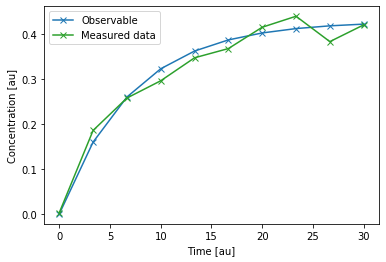

In [44]:
import pyabc
from study_abc_noise.model import \
    ConversionReaction1dModelVars as ModelVars
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import logging
%matplotlib inline

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Acceptor')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Epsilon')
df_logger.setLevel(logging.DEBUG)

# model
mv = ModelVars(n_t=8)

# data
data = mv.get_model_noisy()(mv.p_true)

# plot it
mv.viz_data_and_sim(data)

Let us set out with a wrong algorithm which ignores the noise:

In [45]:
# define the analysis
abc = pyabc.ABCSMC(
    models=mv.get_model(),
    parameter_priors=mv.get_prior(),
    distance_function=mv.get_distance())
abc.new(pyabc.create_sqlite_db_id(), data)
history = abc.run(max_nr_populations=8, minimum_epsilon=0.)

DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1
INFO:History:Start <ABCSMC(id=127, start_time=2019-10-24 10:51:26.453734, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 235.6273342428916
INFO:ABC:t: 0, eps: 235.6273342428916.
INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01.
DEBUG:Epsilon:new eps, t=1, eps=52.11795490883916
INFO:ABC:t: 1, eps: 52.11795490883916.
INFO:ABC:Acceptance rate: 100 / 231 = 4.3290e-01.
DEBUG:Epsilon:new eps, t=2, eps=17.716433646553597
INFO:ABC:t: 2, eps: 17.716433646553597.
INFO:ABC:Acceptance rate: 100 / 209 = 4.7847e-01.
DEBUG:Epsilon:new eps, t=3, eps=12.381969889752643
INFO:ABC:t: 3, eps: 12.381969889752643.
INFO:ABC:Acceptance rate: 100 / 189 = 5.2910e-01.
DEBUG:Epsilon:new eps, t=4, eps=10.481535651769883
INFO:ABC:t: 4, eps: 10.481535651769883.
INFO:ABC:Acceptance rate: 100 / 200 = 5.0000e-01.
DEBUG:Epsilon:new eps, t=5, eps=9.931933475132109
INFO:ABC:t: 5, eps: 9.9319334751

What does our posterior approximation look like?

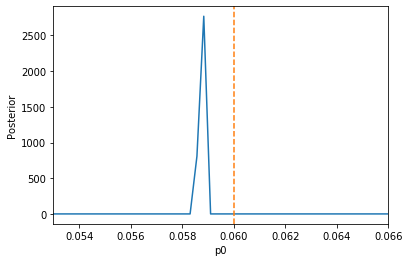

In [46]:
df, w = history.get_distribution()
pyabc.visualization.plot_kde_1d(
    df, w, 'p0', xmin=mv.limits['p0'][0], xmax=mv.limits['p0'][1],
    refval=mv.p_true)

Now let's noisify our model output:

In [57]:
# define the analysis
abc = pyabc.ABCSMC(
    models=mv.get_model_noisy(),
    parameter_priors=mv.get_prior(),
    distance_function=mv.get_distance())
abc.new(pyabc.create_sqlite_db_id(), data)
history_noise = abc.run(max_nr_populations=12, minimum_epsilon=0.)

DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1
INFO:History:Start <ABCSMC(id=133, start_time=2019-10-24 10:59:59.097231, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 245.53208553319527
INFO:ABC:t: 0, eps: 245.53208553319527.
INFO:ABC:Acceptance rate: 100 / 213 = 4.6948e-01.
DEBUG:Epsilon:new eps, t=1, eps=60.1726021807745
INFO:ABC:t: 1, eps: 60.1726021807745.
INFO:ABC:Acceptance rate: 100 / 239 = 4.1841e-01.
DEBUG:Epsilon:new eps, t=2, eps=25.416934004696184
INFO:ABC:t: 2, eps: 25.416934004696184.
INFO:ABC:Acceptance rate: 100 / 253 = 3.9526e-01.
DEBUG:Epsilon:new eps, t=3, eps=17.812274659046132
INFO:ABC:t: 3, eps: 17.812274659046132.
INFO:ABC:Acceptance rate: 100 / 344 = 2.9070e-01.
DEBUG:Epsilon:new eps, t=4, eps=13.717258758110258
INFO:ABC:t: 4, eps: 13.717258758110258.
INFO:ABC:Acceptance rate: 100 / 655 = 1.5267e-01.
DEBUG:Epsilon:new eps, t=5, eps=10.901326838511725
INFO:ABC:t: 5, eps: 10.90132683

Now, out approximation looks as follows:

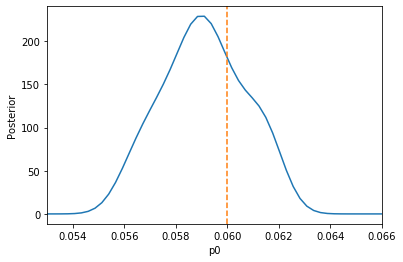

In [58]:
df, w = history_noise.get_distribution()
pyabc.visualization.plot_kde_1d(
    df, w, 'p0', xmin=mv.limits['p0'][0], xmax=mv.limits['p0'][1],
    refval=mv.p_true)

We will now employ different algorithms, all of which give us correct exact inference. Let's start with basic rejection sampling:

In [49]:
acceptor = pyabc.StochasticAcceptor(pdf_norm_method=pyabc.pdf_norm_from_kernel)
temperature = pyabc.Temperature()

# define the analysis
abc = pyabc.ABCSMC(
    models=mv.get_model(),
    parameter_priors=mv.get_prior(),
    distance_function=mv.get_kernel(),
    eps=temperature,
    acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), data)
history0 = abc.run(max_nr_populations=1, minimum_epsilon=1.)

INFO:History:Start <ABCSMC(id=129, start_time=2019-10-24 10:51:59.914180, end_time=None)>
DEBUG:Acceptor:pdf_norm=2.9931e+01 for t=0.
INFO:ABC:t: 0, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 194862 = 5.1318e-04.
DEBUG:Acceptor:pdf_norm=2.9931e+01 for t=1.
INFO:History:Done <ABCSMC(id=129, start_time=2019-10-24 10:51:59.914180, end_time=2019-10-24 10:52:32.515762)>


Now let's try SMC:

In [50]:
acceptor = pyabc.StochasticAcceptor(pdf_norm_method=pyabc.pdf_norm_from_kernel)
temperature = pyabc.Temperature()

# define the analysis
abc = pyabc.ABCSMC(
    models=mv.get_model(),
    parameter_priors=mv.get_prior(),
    distance_function=mv.get_kernel(),
    eps=temperature,
    acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), data)
history1 = abc.run(max_nr_populations=8, minimum_epsilon=1.)

INFO:History:Start <ABCSMC(id=130, start_time=2019-10-24 10:52:32.596737, end_time=None)>
DEBUG:Acceptor:pdf_norm=2.9931e+01 for t=0.
INFO:ABC:Calibration sample before t=0.
DEBUG:Epsilon:Proposed temperatures: [126.85052562551229, inf].
INFO:ABC:t: 0, eps: 126.85052562551229.
INFO:ABC:Acceptance rate: 100 / 231 = 4.3290e-01.
DEBUG:Acceptor:pdf_norm=2.9931e+01 for t=1.
DEBUG:Epsilon:Proposed temperatures: [33.94371034347359, 63.5070510413347].
INFO:ABC:t: 1, eps: 33.94371034347359.
INFO:ABC:Acceptance rate: 100 / 227 = 4.4053e-01.
DEBUG:Acceptor:pdf_norm=2.9931e+01 for t=2.
DEBUG:Epsilon:Proposed temperatures: [16.307399006996, 18.863955385828827].
INFO:ABC:t: 2, eps: 16.307399006996.
INFO:ABC:Acceptance rate: 100 / 235 = 4.2553e-01.
DEBUG:Acceptor:pdf_norm=2.9931e+01 for t=3.
DEBUG:Epsilon:Proposed temperatures: [12.549584195387732, 9.33056103390708].
INFO:ABC:t: 3, eps: 9.33056103390708.
INFO:ABC:Acceptance rate: 100 / 262 = 3.8168e-01.
DEBUG:Acceptor:pdf_norm=2.9931e+01 for t=4.
DEB

Now let's try basic rejection sampling with rejection control importance sampling:

In [51]:
acceptor = pyabc.StochasticAcceptor()
temperature = pyabc.Temperature()

# define the analysis
abc = pyabc.ABCSMC(
    models=mv.get_model(),
    parameter_priors=mv.get_prior(),
    distance_function=mv.get_kernel(),
    eps=temperature,
    acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), data)
history2 = abc.run(max_nr_populations=1, minimum_epsilon=1.)

INFO:History:Start <ABCSMC(id=131, start_time=2019-10-24 10:53:08.880705, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=2.5004e+01 for t=0.
INFO:ABC:t: 0, eps: 1.0.
DEBUG:Acceptor:Encountered pd=2.5044e+01 > c=2.5004e+01, thus weight=1.0415e+00.
DEBUG:Acceptor:Encountered pd=2.5032e+01 > c=2.5004e+01, thus weight=1.0287e+00.
DEBUG:Acceptor:Encountered pd=2.5035e+01 > c=2.5004e+01, thus weight=1.0312e+00.
DEBUG:Acceptor:Encountered pd=2.5044e+01 > c=2.5004e+01, thus weight=1.0406e+00.
DEBUG:Acceptor:Encountered pd=2.5042e+01 > c=2.5004e+01, thus weight=1.0384e+00.
DEBUG:Acceptor:Encountered pd=2.5032e+01 > c=2.5004e+01, thus weight=1.0283e+00.
DEBUG:Acceptor:Encountered pd=2.5020e+01 > c=2.5004e+01, thus weight=1.0167e+00.
DEBUG:Acceptor:Encountered pd=2.5022e+01 > c=2.5004e+01, thus weight=1.0185e+00.
DEBUG:Acceptor:Encountered pd=2.5052e+01 > c=2.5004e+01, thus weight=1.0493e+00.
DEBUG:Acceptor:Encountered pd=2.5031e+01 > c=2.5004e+01, thus weight=1.0

Now let's combine everything:

In [52]:
acceptor = pyabc.StochasticAcceptor()
temperature = pyabc.Temperature()

# define the analysis
abc = pyabc.ABCSMC(
    models=mv.get_model(),
    parameter_priors=mv.get_prior(),
    distance_function=mv.get_kernel(),
    eps=temperature,
    acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), data)
history3 = abc.run(max_nr_populations=5, minimum_epsilon=1.)

INFO:History:Start <ABCSMC(id=132, start_time=2019-10-24 10:53:09.959517, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=2.4980e+01 for t=0.
DEBUG:Epsilon:Proposed temperatures: [152.22154787603645, inf].
INFO:ABC:t: 0, eps: 152.22154787603645.
DEBUG:Acceptor:Encountered pd=2.5020e+01 > c=2.4980e+01, thus weight=1.0003e+00.
DEBUG:Acceptor:Encountered pd=2.4999e+01 > c=2.4980e+01, thus weight=1.0001e+00.
INFO:ABC:Acceptance rate: 100 / 182 = 5.4945e-01.
DEBUG:Acceptor:pdf_norm=2.5020e+01 for t=1.
DEBUG:Epsilon:Proposed temperatures: [40.92729456482556, 43.336826002559356].
INFO:ABC:t: 1, eps: 40.92729456482556.
DEBUG:Acceptor:Encountered pd=2.5052e+01 > c=2.5020e+01, thus weight=1.0008e+00.
DEBUG:Acceptor:Encountered pd=2.5029e+01 > c=2.5020e+01, thus weight=1.0002e+00.
DEBUG:Acceptor:Encountered pd=2.5048e+01 > c=2.5020e+01, thus weight=1.0007e+00.
INFO:ABC:Acceptance rate: 100 / 223 = 4.4843e-01.
DEBUG:Acceptor:pdf_norm=2.5052e+01 for t=2.
DEBUG:Epsilo

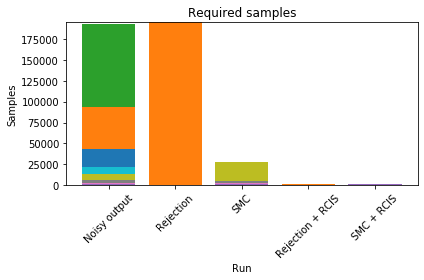

In [60]:
pyabc.visualization.plot_sample_numbers(
    [history_noise, history0, history1, history2, history3],
    ["Noisy output", "Rejection", "SMC", "Rejection + RCIS", "SMC + RCIS"],
    rotation=45)

Let's focus on the last two (to see anything at all):

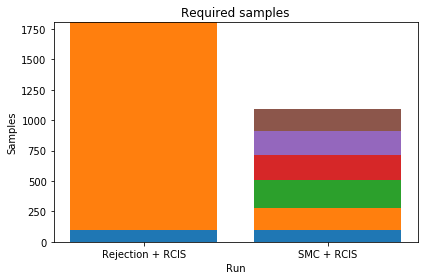

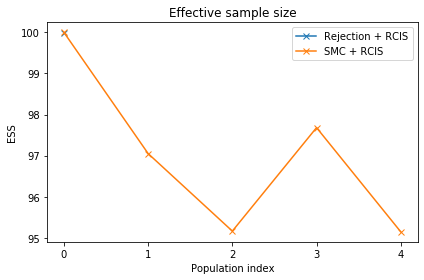

In [54]:
pyabc.visualization.plot_sample_numbers(
    [history2, history3], ["Rejection + RCIS", "SMC + RCIS"])
pyabc.visualization.plot_effective_sample_sizes(
    [history2, history3], ["Rejection + RCIS", "SMC + RCIS"])

Looking good. Let's shortly check what our posterior looks like now:

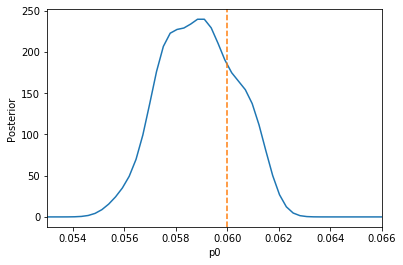

In [55]:
df, w = history3.get_distribution()
pyabc.visualization.plot_kde_1d(
    df, w, 'p0', xmin=mv.limits['p0'][0], xmax=mv.limits['p0'][1],
    refval=mv.p_true)

Did our acceptance rate scheduler work as intended?

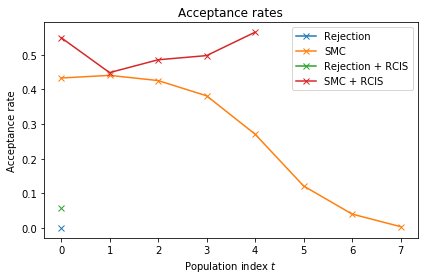

In [56]:
pyabc.visualization.plot_acceptance_rates_trajectory(
    [history0, history1, history2, history3],
    ["Rejection", "SMC", "Rejection + RCIS", "SMC + RCIS"])

## MJP model

Not convinced yet? Let's go for a tougher model, in particular a non-deterministic one. Now we employ a MJP model of gene expression:

In [17]:
import pyabc
from study_abc_noise.model import MRNATranscriptionModelVars as ModelVars
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import logging
%matplotlib inline

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Acceptor')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Epsilon')
df_logger.setLevel(logging.DEBUG)

# model
mv = ModelVars(n_t=4)

# data
data = mv.get_model_noisy()(mv.p_true)

In [18]:
acceptor = pyabc.StochasticAcceptor()
temperature = pyabc.Temperature()

# define the analysis
abc = pyabc.ABCSMC(
    models=mv.get_model(),
    parameter_priors=mv.get_prior(),
    distance_function=mv.get_kernel(),
    eps=temperature,
    acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), data)
history_mrna0 = abc.run(max_nr_populations=1, minimum_epsilon=1.)


acceptor = pyabc.StochasticAcceptor()
temperature = pyabc.Temperature()

# define the analysis
abc = pyabc.ABCSMC(
    models=mv.get_model(),
    parameter_priors=mv.get_prior(),
    distance_function=mv.get_kernel(),
    eps=temperature,
    acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), data)
history_mrna1 = abc.run(max_nr_populations=20, minimum_epsilon=1.)

INFO:History:Start <ABCSMC(id=113, start_time=2019-10-24 00:50:52.996769, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=-2.9461e+01 for t=0.
INFO:ABC:t: 0, eps: 1.0.
DEBUG:Acceptor:Encountered pd=-2.8545e+01 > c=-2.9461e+01, thus weight=2.4990e+00.
DEBUG:Acceptor:Encountered pd=-2.2145e+01 > c=-2.9461e+01, thus weight=1.5049e+03.
DEBUG:Acceptor:Encountered pd=-2.6644e+01 > c=-2.9461e+01, thus weight=1.6722e+01.
DEBUG:Acceptor:Encountered pd=-2.4248e+01 > c=-2.9461e+01, thus weight=1.8371e+02.
DEBUG:Acceptor:Encountered pd=-2.8001e+01 > c=-2.9461e+01, thus weight=4.3082e+00.
DEBUG:Acceptor:Encountered pd=-2.7948e+01 > c=-2.9461e+01, thus weight=4.5388e+00.
DEBUG:Acceptor:Encountered pd=-2.0914e+01 > c=-2.9461e+01, thus weight=5.1499e+03.
DEBUG:Acceptor:Encountered pd=-1.4182e+01 > c=-2.9461e+01, thus weight=4.3192e+06.
DEBUG:Acceptor:Encountered pd=-2.8493e+01 > c=-2.9461e+01, thus weight=2.6333e+00.
DEBUG:Acceptor:Encountered pd=-1.6951e+01 > c=-2.9461

INFO:ABC:Acceptance rate: 100 / 211 = 4.7393e-01.
DEBUG:Acceptor:pdf_norm=-1.4819e+01 for t=2.
DEBUG:Epsilon:Proposed temperatures: [162.22270708723312, 210.82864075187163].
INFO:ABC:t: 2, eps: 162.22270708723312.
DEBUG:Acceptor:Encountered pd=-1.2849e+01 > c=-1.4819e+01, thus weight=1.0122e+00.
INFO:ABC:Acceptance rate: 100 / 253 = 3.9526e-01.
DEBUG:Acceptor:pdf_norm=-1.2849e+01 for t=3.
DEBUG:Epsilon:Proposed temperatures: [94.04116826048134, 120.255535640435].
INFO:ABC:t: 3, eps: 94.04116826048134.
DEBUG:Acceptor:Encountered pd=-1.0111e+01 > c=-1.2849e+01, thus weight=1.0295e+00.
DEBUG:Acceptor:Encountered pd=-1.1304e+01 > c=-1.2849e+01, thus weight=1.0166e+00.
INFO:ABC:Acceptance rate: 100 / 329 = 3.0395e-01.
DEBUG:Acceptor:pdf_norm=-1.0111e+01 for t=4.
DEBUG:Epsilon:Proposed temperatures: [67.85667840005856, 70.79223759484886].
INFO:ABC:t: 4, eps: 67.85667840005856.
DEBUG:Acceptor:Encountered pd=-8.2708e+00 > c=-1.0111e+01, thus weight=1.0275e+00.
DEBUG:Acceptor:Encountered pd=-8.

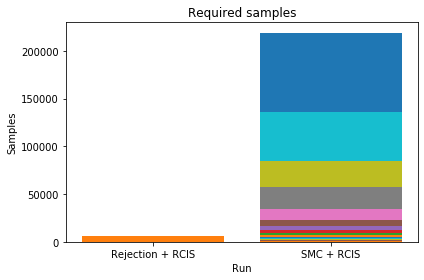

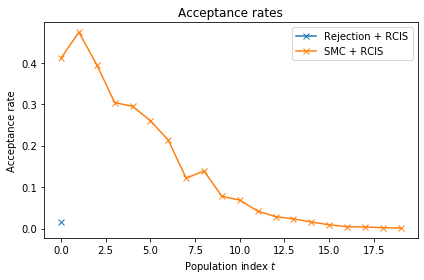

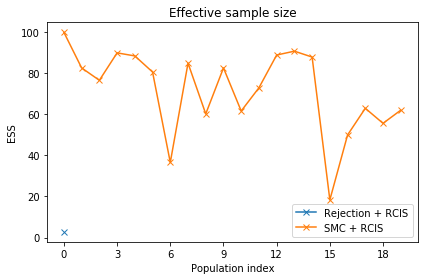

In [19]:
pyabc.visualization.plot_sample_numbers(
    [history_mrna0, history_mrna1], ["Rejection + RCIS", "SMC + RCIS"])

pyabc.visualization.plot_acceptance_rates_trajectory(
    [history_mrna0, history_mrna1], ["Rejection + RCIS", "SMC + RCIS"])

pyabc.visualization.plot_effective_sample_sizes(
    [history_mrna0, history_mrna1], ["Rejection + RCIS", "SMC + RCIS"])

## SDE model

Next, we consider an SDE model of ion channel activation:

In [20]:
import pyabc
from study_abc_noise.model import HodgkinHuxleyModelVars as ModelVars
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import logging
%matplotlib inline

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Acceptor')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Epsilon')
df_logger.setLevel(logging.DEBUG)

# model
mv = ModelVars(n_t=10)

# data
data = mv.get_model_noisy()(mv.p_true)

In [21]:
acceptor = pyabc.StochasticAcceptor()
temperature = pyabc.Temperature()

# define the analysis
abc = pyabc.ABCSMC(
    models=mv.get_model(),
    parameter_priors=mv.get_prior(),
    distance_function=mv.get_kernel(),
    eps=temperature,
    acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), data)
history_hh0 = abc.run(max_nr_populations=1, minimum_epsilon=1.)

acceptor = pyabc.StochasticAcceptor()
temperature = pyabc.Temperature()

# define the analysis
abc = pyabc.ABCSMC(
    models=mv.get_model(),
    parameter_priors=mv.get_prior(),
    distance_function=mv.get_kernel(),
    eps=temperature,
    acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), data)
history_hh1 = abc.run(max_nr_populations=10, minimum_epsilon=1.)

INFO:History:Start <ABCSMC(id=115, start_time=2019-10-24 02:24:59.037249, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=1.6565e+01 for t=0.
INFO:ABC:t: 0, eps: 1.0.
DEBUG:Acceptor:Encountered pd=1.6735e+01 > c=1.6565e+01, thus weight=1.1854e+00.
DEBUG:Acceptor:Encountered pd=1.7398e+01 > c=1.6565e+01, thus weight=2.3022e+00.
DEBUG:Acceptor:Encountered pd=1.7599e+01 > c=1.6565e+01, thus weight=2.8137e+00.
DEBUG:Acceptor:Encountered pd=1.6660e+01 > c=1.6565e+01, thus weight=1.1006e+00.
DEBUG:Acceptor:Encountered pd=1.7019e+01 > c=1.6565e+01, thus weight=1.5754e+00.
DEBUG:Acceptor:Encountered pd=1.6830e+01 > c=1.6565e+01, thus weight=1.3042e+00.
DEBUG:Acceptor:Encountered pd=1.7200e+01 > c=1.6565e+01, thus weight=1.8875e+00.
DEBUG:Acceptor:Encountered pd=1.6888e+01 > c=1.6565e+01, thus weight=1.3813e+00.
DEBUG:Acceptor:Encountered pd=1.7391e+01 > c=1.6565e+01, thus weight=2.2862e+00.
DEBUG:Acceptor:Encountered pd=1.6974e+01 > c=1.6565e+01, thus weight=1.5

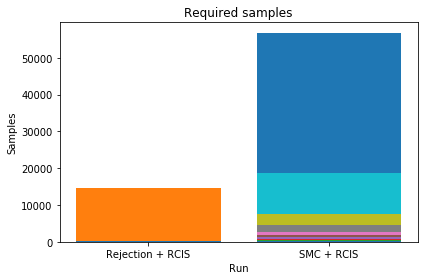

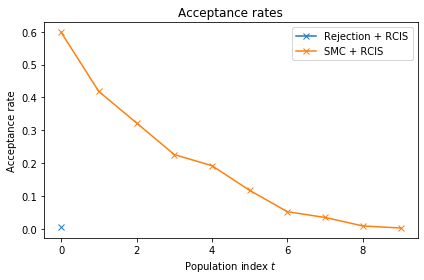

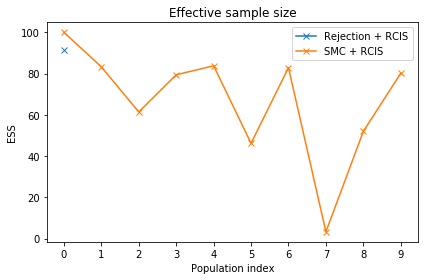

In [22]:
pyabc.visualization.plot_sample_numbers(
    [history_hh0, history_hh1], ["Rejection + RCIS", "SMC + RCIS"])

pyabc.visualization.plot_acceptance_rates_trajectory(
    [history_hh0, history_hh1], ["Rejection + RCIS", "SMC + RCIS"])

pyabc.visualization.plot_effective_sample_sizes(
    [history_hh0, history_hh1], ["Rejection + RCIS", "SMC + RCIS"])